<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> RAMP on charged particle tracking with ATLAS detector </h2>

<i> Thomas Boser, Mikhail Hushchyn, Balázs Kégl, David Rousseau, Yetkin Yılmaz </i>

<h2> Introduction </h2>

<p> 

<p>The main objective is to achive the optimal assignment of each hit to a track id.



### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [2]:
filename = "hits_merged.csv"
df = pd.read_csv(filename)
y_df = df[['particle']] + 1000 * df[['event']].values
X_df = df.drop(['particle'], axis=1)

(particle ids are shifted by 1000 times the event id, in order to make them unique across the dataset)

### Visualize the hits in a single event

In [64]:
ievent = 0
X_df_event = X_df.loc[X_df['event']==ievent]
pixelx = X_df_event['x'].values
pixely = X_df_event['y'].values
particles = y_df.loc[X_df['event']==ievent]['particle'].values

#### Hits from all particles

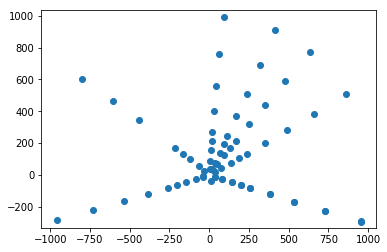

In [65]:
plt.scatter(pixelx,pixely)
plt.axis('equal')
plt.show()

This is what the algorithm will see.

#### Hits from a single particle

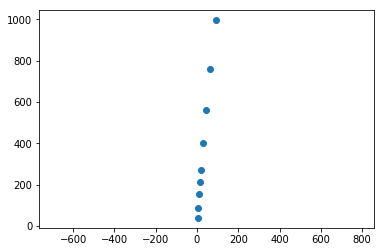

In [66]:
iparticle = 2
iparticle += ievent * 1000
hits_particle = (particles == iparticle)
plt.scatter(pixelx[hits_particle],pixely[hits_particle])
plt.axis('equal')
plt.show()

So, ideally, our algorithm wants to assign specific ids to all hits in a way that corresponds to the particle. The perfect algorithm will split the event into various tracks:

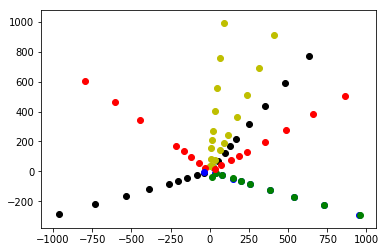

In [67]:
cmap = ['k','b','y','g','r']
for iparticle in np.unique(particles):
    hits_particle = (particles == iparticle)
    plt.scatter(pixelx[hits_particle],pixely[hits_particle],color=cmap[int(iparticle) % 5])
plt.show()

### Matching the hits together

In [68]:
import Hough
tracker = Hough.Hough(n_theta_bins=100, n_radius_bins=100, min_radius=1., min_hits=4)

#### Training the algorithm

In [77]:
tracker.fit(X_df.values, y_df.values)

#### Running the algorithm to reconstruct the tracks in data

In [70]:
y_true = y_df['particle'].values
y_predicted = tracker.predict(X_df.values)

In [71]:
y_df['track'] = y_predicted

Let's compare how well the tracks corresponds to the particles

In [72]:
y_df[(X_df['event']==7).values].sort(['particle'])

,particle,track
567,7000,0
564,7000,1
566,7000,0
570,7000,-1
589,7000,0
588,7000,0
581,7000,-1
576,7000,0
548,7000,0
552,7001,0


In [73]:
tracks = y_predicted[(X_df['event']==ievent).values]

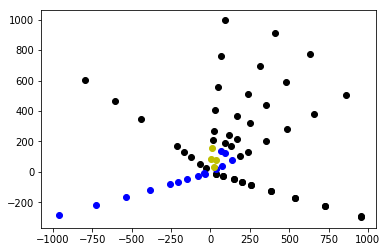

In [74]:
cmap = ['k','b','y','g','r']
for itrack in np.unique(tracks):
    if itrack >= 0:
        hits_track = (tracks == itrack)
        plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

### Scoring the assignment

The score function measures the fraction of hits with good track assignment

In [75]:
def score(y_test, y_pred):
    
    eff_total = 0.
    
    particles = np.unique(y_test)
    npart = len(particles)
    nhit = len(y_test)
    
    assignedtrack = np.full(shape=npart,fill_value=-1, dtype='int64')
    hitintrack = np.full(shape=npart,fill_value=0, dtype='int64')
    eff = np.full(shape=npart,fill_value=0.)
    con = np.full(shape=npart,fill_value=0.)
    
    # assign tracks to particles
    ipart = 0
    for particle in particles:
        
        eff[ipart] = 0.
        con[ipart] = 0.
        
        true_hits = y_test[y_test[:] == particle]
        found_hits = y_pred[y_test[:] == particle]
        
        nsubcluster=len(np.unique(found_hits[found_hits[:] >= 0]))
        
        if(nsubcluster > 0):
            b=np.bincount((found_hits[found_hits[:] >= 0]).astype(dtype='int64'))
            a=np.argmax(b)
            
            maxcluster = a
            
            assignedtrack[ipart]=maxcluster
            hitintrack[ipart]=len(found_hits[found_hits[:] == maxcluster])
   
        ipart += 1
    
    
    # resolve duplicates and count good assignments
    ipart = 0
    sorted=np.argsort(hitintrack)
    hitintrack=hitintrack[sorted]
    assignedtrack=assignedtrack[sorted]
    for particle in particles:
        itrack=assignedtrack[ipart]
        if((itrack < 0) | (len(assignedtrack[assignedtrack[:] == itrack])>1)):
            hitintrack = np.delete(hitintrack,ipart)
            assignedtrack = np.delete(assignedtrack,ipart)
        else:
            ipart += 1
    ngood = 0.
    ngood = np.sum(hitintrack)
    eff_total = eff_total + (float(ngood) / float(nhit))
    
    # remove combinatorials
    print npart, nhit, eff_total
    return eff_total



In [76]:
score(y_true, y_predicted)

10967 92023 0.000369472849179


0.0003694728491790096

### Fitting the tracks (beyond the challenge)